In [555]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import re

from phik import phik_matrix

import scipy.stats as stats

from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.combine import SMOTETomek
from imblearn.pipeline import Pipeline as ImbPipeline

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold

from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve, roc_auc_score, RocCurveDisplay
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder

from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier

from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.losses import categorical_crossentropy
from keras.optimizers import Adam
from keras.utils import to_categorical

import warnings
warnings.filterwarnings("ignore")

RANDOM_STATE=654321
TEST_SIZE=0.3

In [240]:
class Transformator():
    
    ''' Функция по приведению столбцов к типу данных bool'''
    def to_type_bool(self, df:pd.DataFrame, columns : list) -> pd.DataFrame:
        for column in columns:
            df[column] = df[column].astype('bool') 
        print(df.info())
        return df
        
    ''' Функция по созданию признака  длительности пребывания в стационаре до момента операции''' 
    def time_between_check_inn_and_operation(self, df):
        for i,row in df.iterrows():
            df.loc[i,'время_ожидания_операции'] = (df.loc[i,'дата_операции'] - df.loc[i,'дата_поступления']).days*24          
        return df

def feature_importance(importances, feature_names, top_n=20):
    """
    Функция для построения графика feature importance.

    Параметры:
    - importances: массив важности признаков
    - feature_names: массив имен признаков
    - top_n: количество первых признаков, которые нужно отобразить (по умолчанию 20)
    """
    # Создаем DataFrame для удобства отображения
    feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
    
    # Отсортируем по важности
    feature_importance_df = feature_importance_df.sort_values(by='Importance')
    
    # Отобразим только первые top_n признаков
    feature_importance_df_top_n = feature_importance_df[-top_n:]
    
    # Построим график важности фичей
    plt.figure(figsize=(10, 10))
    plt.barh(feature_importance_df_top_n['Feature'], feature_importance_df_top_n['Importance'])
    plt.xlabel('Важность признака')
    plt.title('Влияние признаков на работу модели (Топ {})'.format(top_n), loc='left')
    plt.show()

In [241]:
df = pd.read_excel('operations.xlsx')
df.head()

,Год,"Пол (1-мужской, 2 - женский)",Возраст,"Возрастные группы 0-меньше 75, 1 -больше 75",Дата поступления,"ФК стенокардии 1,2,3,4",Курение_1,АГ,"типы СД 2 типа(0-нет, 1-ИНСД, 2-ИЗСД)","Наличие СД 0-нет, 1 есть",...,"ВАБК 0-нет, 1- да","стентированиестволаЛКА 0-нет, 1 да",Число стентированных КА,Число стентов,"Шунтирование ПМЖВ 0-не было, 1 - было","МКШ с ПМЖВ 0-нет, 1 - да","Время ИК, мин","Число шунтов, n","АКШ в анамнезе 0-нет, 1 - да",Осложнения
0,2021,1,74.84,0,2021-05-24T00:00:00+00:00,3,1,1,0,0,...,0,0,0,0,1,1,55,3,0,1
1,2021,1,73.63,0,2021-06-08T00:00:00+00:00,2,1,1,0,0,...,0,0,0,0,1,1,0,5,0,1
2,2021,1,68.15,0,2021-02-24T00:00:00+00:00,4,0,1,1,1,...,0,0,0,0,1,0,0,2,0,0
3,2021,1,73.11,0,2021-02-10T00:00:00+00:00,3,0,1,0,0,...,0,0,0,0,1,1,63,3,0,1
4,2019,1,67.06,0,2019-08-26T00:00:00+00:00,3,0,1,1,1,...,0,0,0,0,1,1,122,3,0,1


In [242]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2232 entries, 0 to 2231
Data columns (total 48 columns):
 #   Column                                       Non-Null Count  Dtype         
---  ------                                       --------------  -----         
 0   Год                                          2232 non-null   int64         
 1   Пол (1-мужской, 2 - женский)                 2232 non-null   int64         
 2   Возраст                                      2232 non-null   float64       
 3   Возрастные группы 0-меньше 75, 1 -больше 75  2232 non-null   int64         
 4   Дата поступления                             2232 non-null   object        
 5   ФК стенокардии 1,2,3,4                       2232 non-null   int64         
 6   Курение_1                                    2232 non-null   int64         
 7   АГ                                           2232 non-null   int64         
 8   типы СД 2 типа(0-нет, 1-ИНСД, 2-ИЗСД)        2232 non-null   int64         
 9

In [243]:
df.columns = ['год', 'пол(1м/2ж)', 'возраст', 'возрастные_группы', 
              'дата_поступления', 'фк_стенокардии', 'курение', 
              'аг' , 'тип_СД2', 'наличие_сд', 'имт' , 'степени_имт', 
              'охс', 'лпнп', 'креатинин', 'скф', 'хбп', 'чкв',
              'мфа', 'пикс', 'экг', 'офв_лж', 'сужение_вса>70%',
              'сужение_магистр.артерий_нк>70%', 'поражение_ствола_лка>50%',
              'поражение_пмжв', 'поражение_1_мак', 'поражение_2_мак',
              'поражение_3_мак', 'euroscore1_abc', 'euroscore1', 'cтепени_euroscore',
              'euroscore2', 'дата_операции', 'акш', 'с_ик', 'стентирование_ка', 'акш_тмлр',
              'вабк', 'стентирование_ствола_лка', 'число_стентированных_ка', 'число_стентов',
              'шунтирование_пмжв', 'мкш_с_пмжв', 'время_ик', 'число_шунтов', 'акш_в_анамнезе', 'осложнения']

In [244]:
bool_columns = (['курение', 'наличие_сд', 'хбп', 'чкв', 
                'мфа', 'пикс', 'сужение_вса>70%', 'сужение_магистр.артерий_нк>70%', 
                'поражение_ствола_лка>50%', 'поражение_пмжв',
                'поражение_1_мак', 'поражение_2_мак', 'поражение_3_мак', 
                'акш', 'с_ик', 'стентирование_ка', 'акш_тмлр', 'вабк',
                'стентирование_ствола_лка', 'шунтирование_пмжв',
                'мкш_с_пмжв', 'акш_в_анамнезе'])
len(bool_columns)

22

In [245]:
df['мкш_с_пмжв'].value_counts()

мкш_с_пмжв
1    1766
0     466
Name: count, dtype: int64

In [246]:
transformator = Transformator()
df = transformator.to_type_bool(df, bool_columns)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2232 entries, 0 to 2231
Data columns (total 48 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   год                             2232 non-null   int64         
 1   пол(1м/2ж)                      2232 non-null   int64         
 2   возраст                         2232 non-null   float64       
 3   возрастные_группы               2232 non-null   int64         
 4   дата_поступления                2232 non-null   object        
 5   фк_стенокардии                  2232 non-null   int64         
 6   курение                         2232 non-null   bool          
 7   аг                              2232 non-null   int64         
 8   тип_СД2                         2232 non-null   int64         
 9   наличие_сд                      2232 non-null   bool          
 10  имт                             2207 non-null   float64       
 11  степ

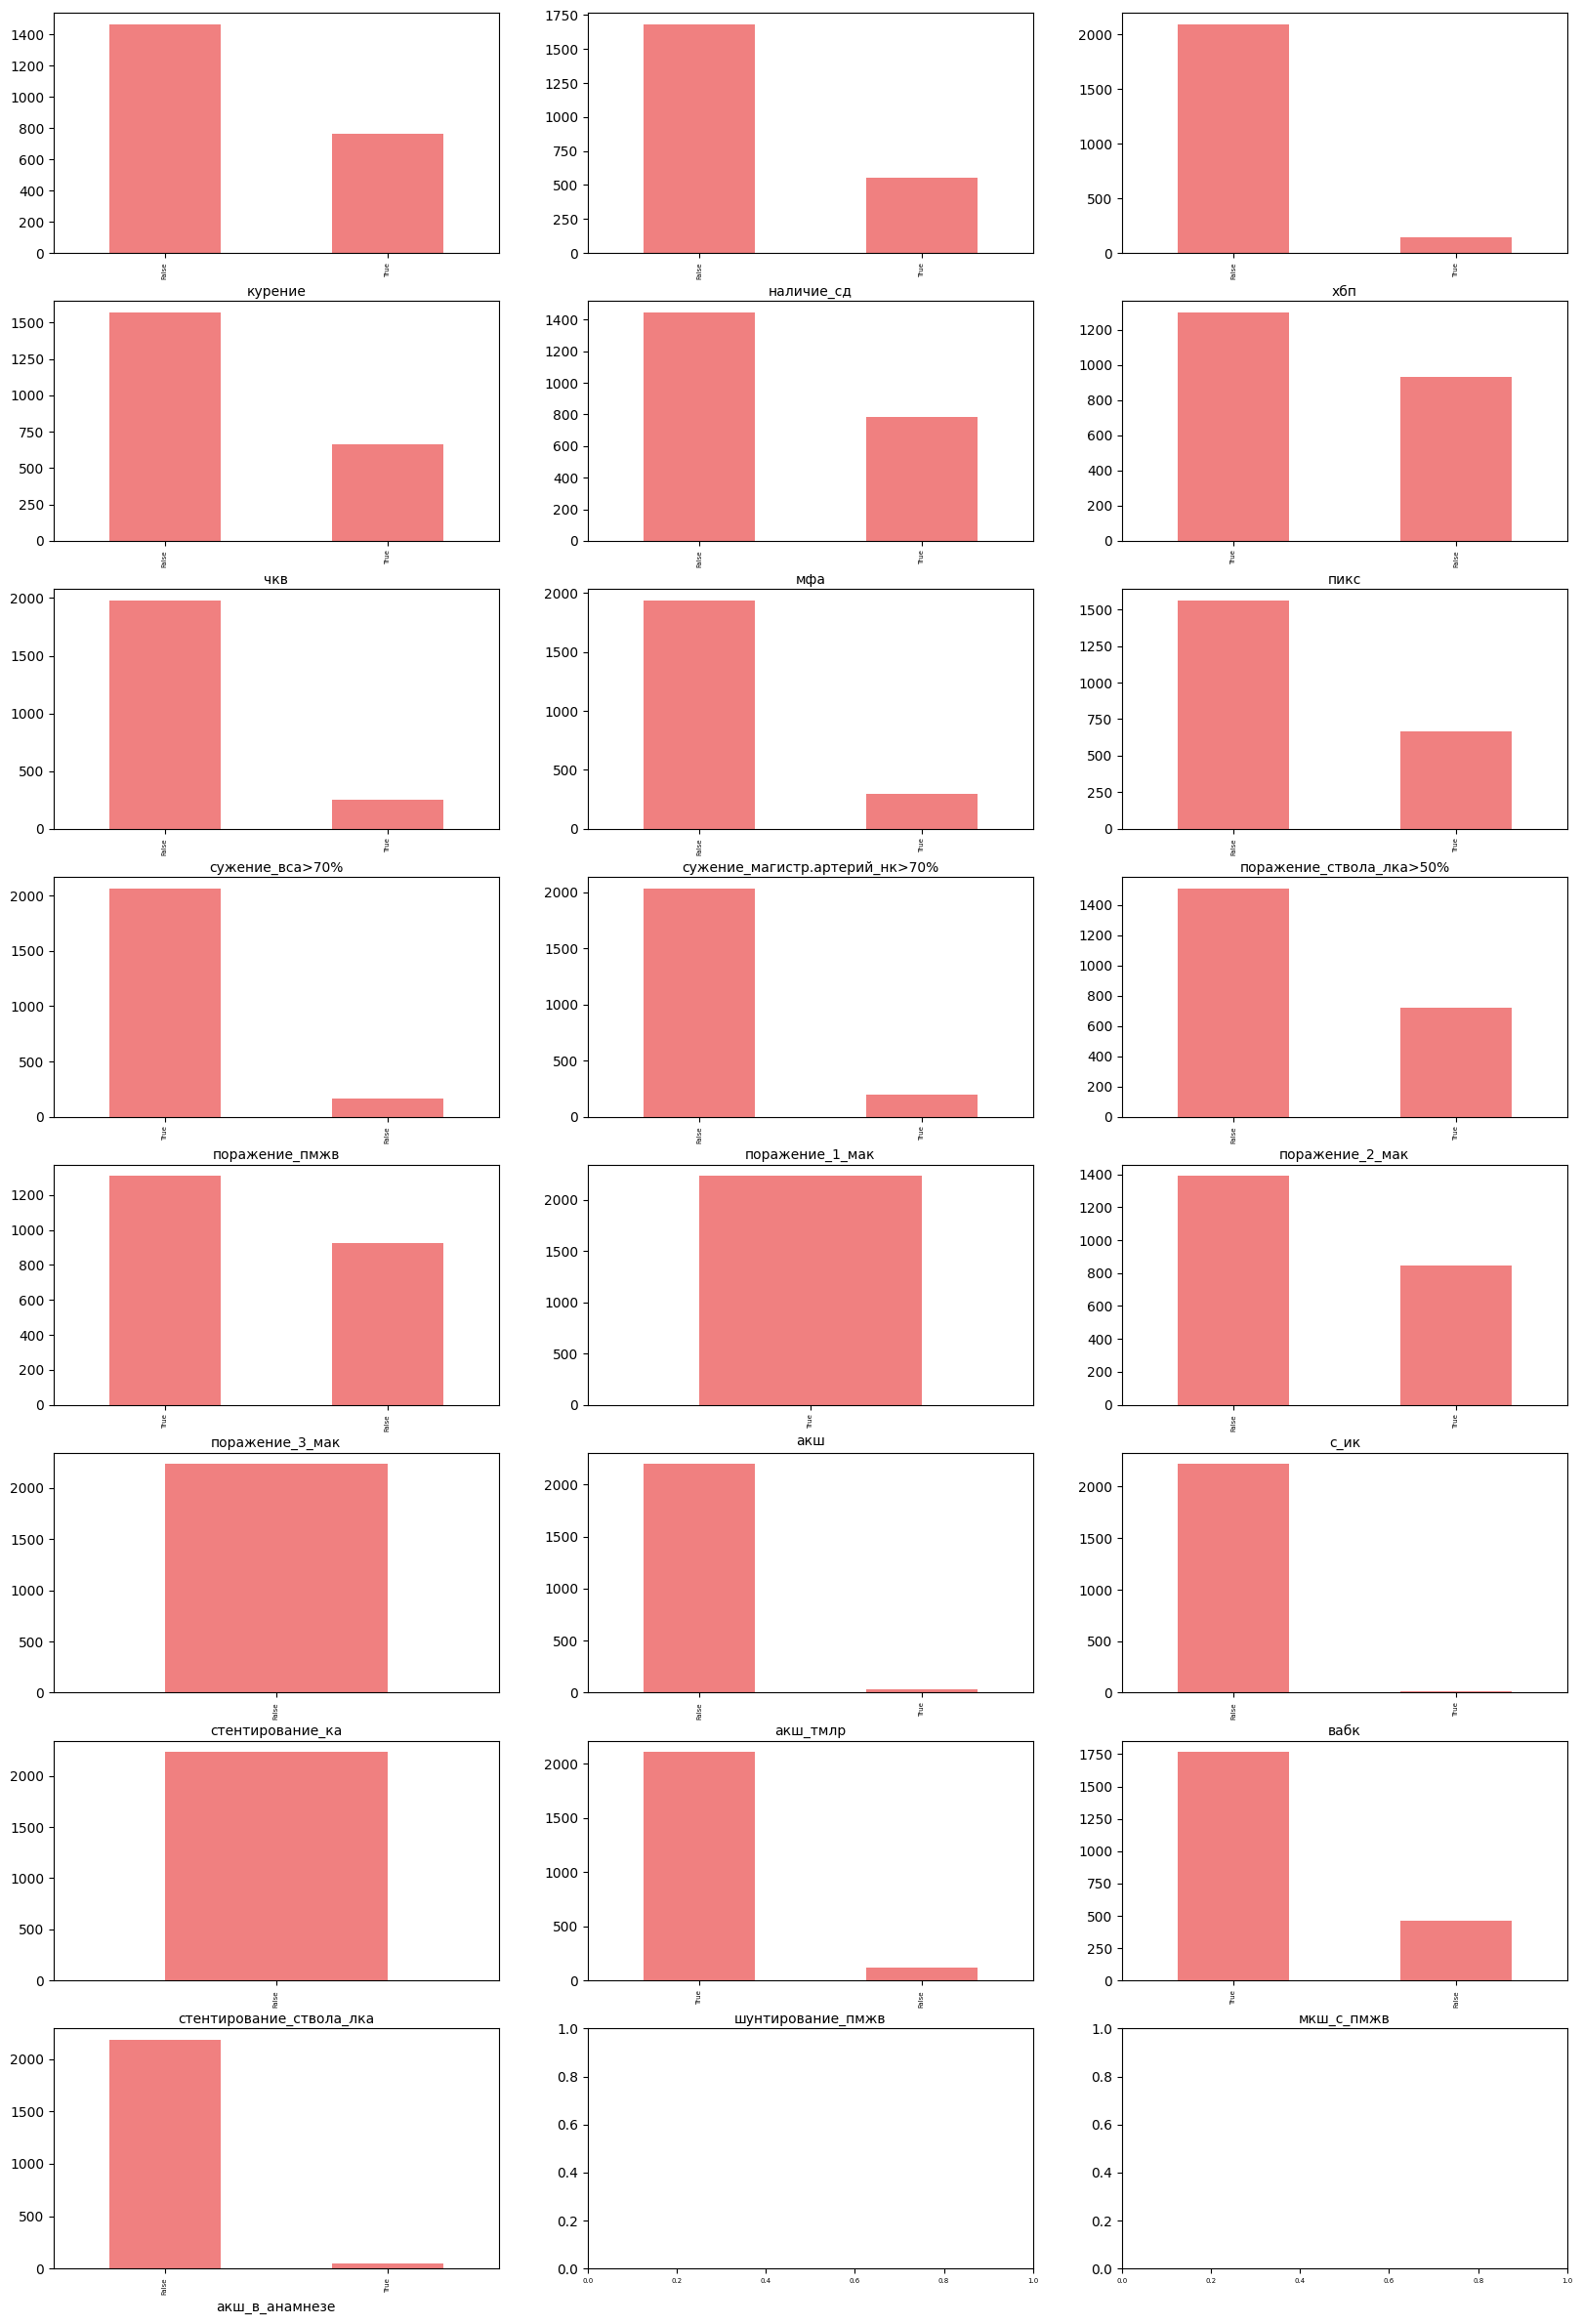

In [247]:
fig, axes = plt.subplots(8, 3, figsize=(20, 30))
plt.rc('xtick',labelsize=5)
for i, column in enumerate(bool_columns):
    row_index = i // 3
    col_index = i % 3
    df[column].value_counts().plot(kind='bar',
                                   ax=axes[row_index, col_index],
                                   color='lightcoral')

In [248]:
# сильный дисбаланс у некоторых признаков
# можно избавиться от 'стентирование_ствола_лка', 'стентирование_ка', 'акш' т.к. у них одно значение 

In [249]:
num_columns = (['год', 'возраст', 'имт', 'охс', 'лпнп', 'креатинин', 'скф', 'офв_лж', 'euroscore1',
                'euroscore2', 'число_стентированных_ка', 'число_стентов',
                'время_ик', 'число_шунтов'])
len(num_columns)

14

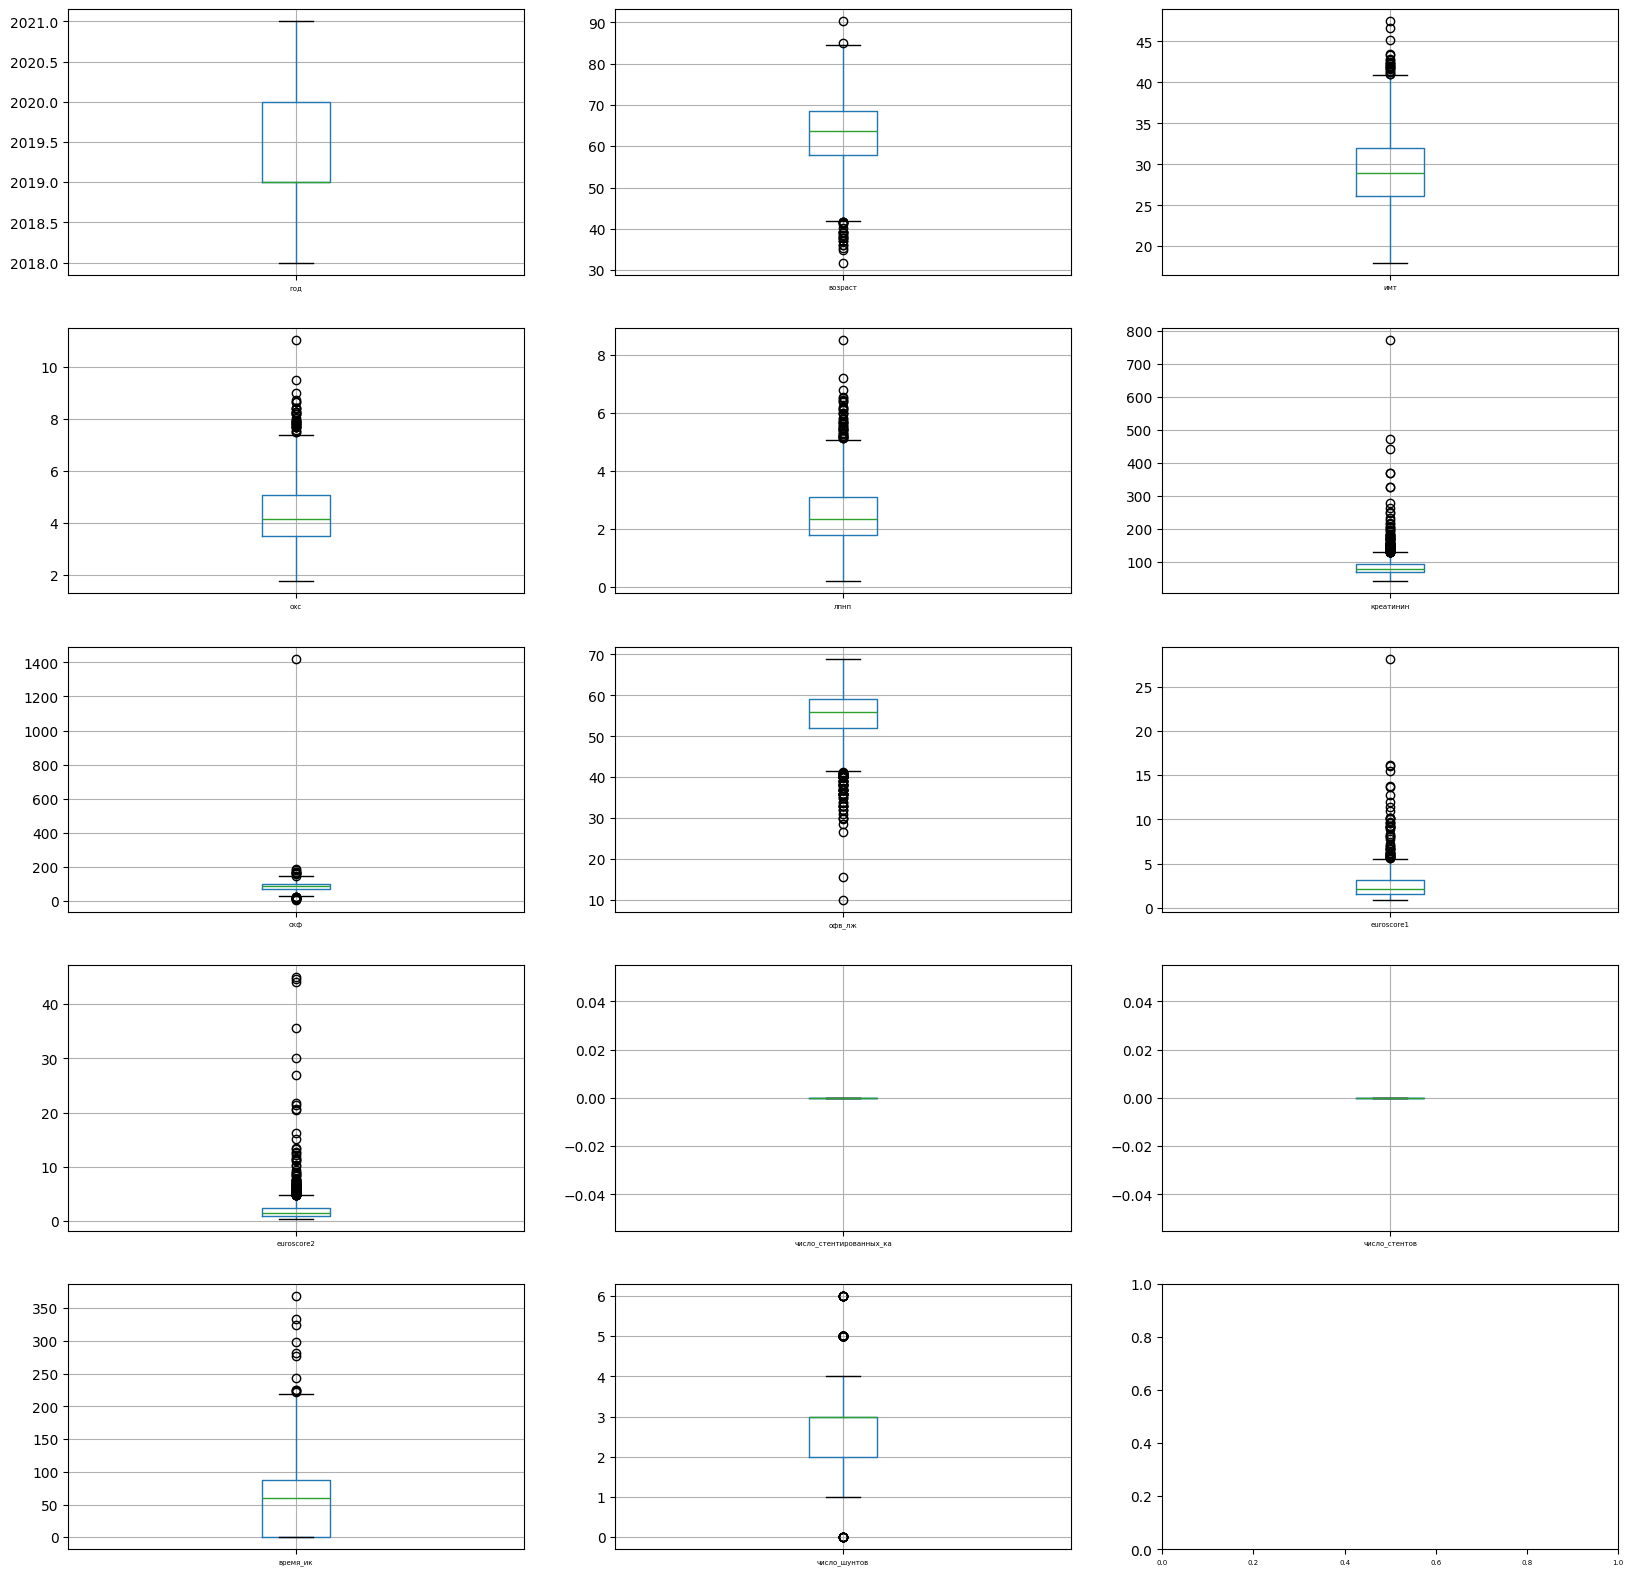

In [250]:
fig, axes = plt.subplots(5, 3, figsize=(20, 20))
for i, column in enumerate(num_columns):
    row_index = i // 3
    col_index = i % 3
    df.boxplot(column=column, ax=axes[row_index, col_index])

In [251]:
# удалим не информативные признаки 'Число стентированных КА ' и 'Число стентов' поскольку они заполнены нулями
df = df.drop(columns = ['число_стентированных_ка', 'число_стентов'])

In [252]:
cat_columns = (['пол(1м/2ж)', 'возрастные_группы', 'фк_стенокардии', 'аг',
                'тип_СД2', 'степени_имт', 'экг', 'euroscore1_abc',
                'cтепени_euroscore'])
len(cat_columns)

9

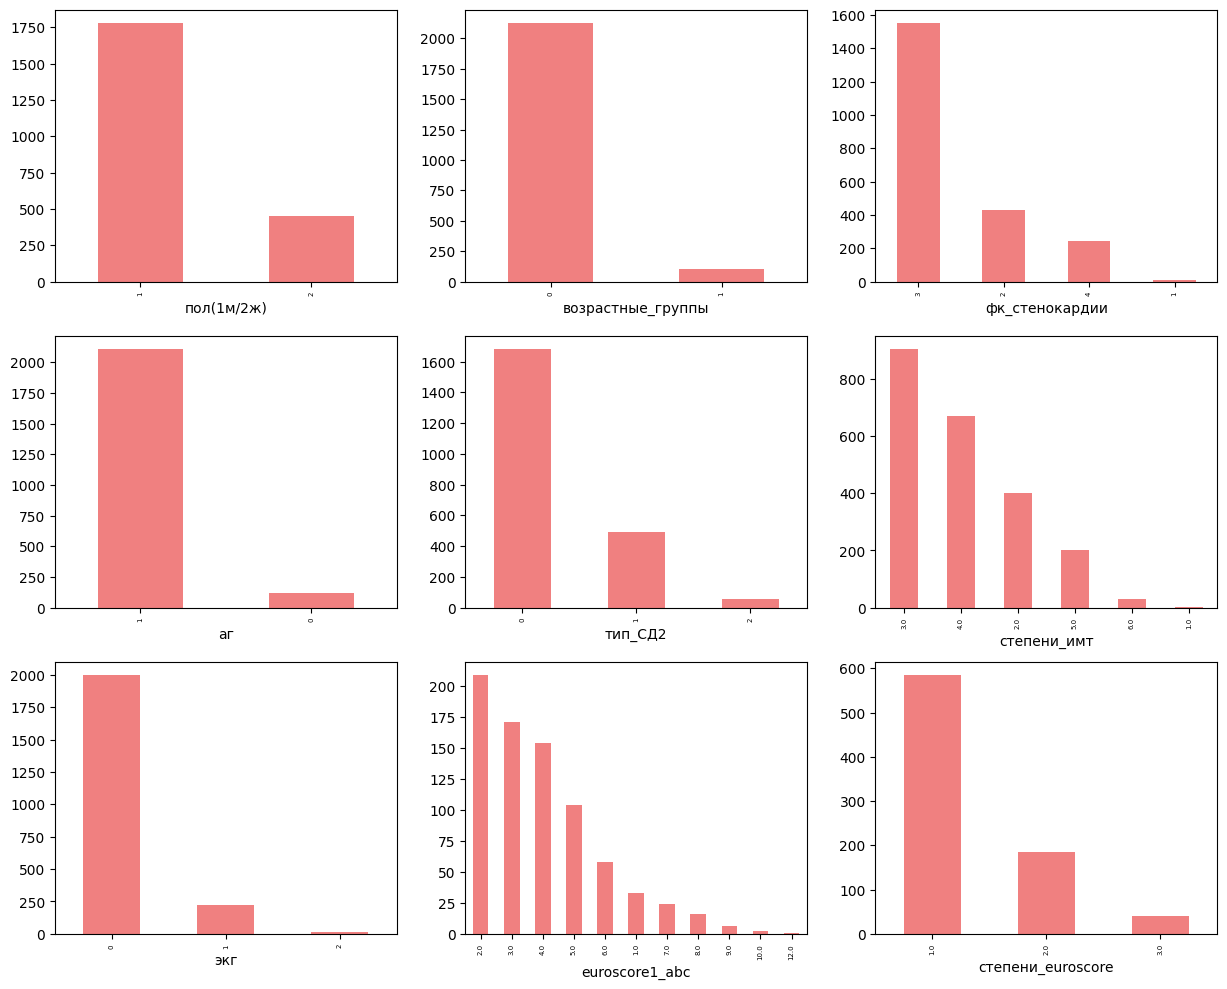

In [253]:
fig, axes = plt.subplots(3, 3, figsize=(15, 12))
for i, column in enumerate(cat_columns):
    row_index = i // 3
    col_index = i % 3
    df[column].value_counts().plot(kind='bar', ax=axes[row_index, col_index], color='lightcoral')

In [254]:
df['возраст'] = df['возраст'].round().astype('int64')

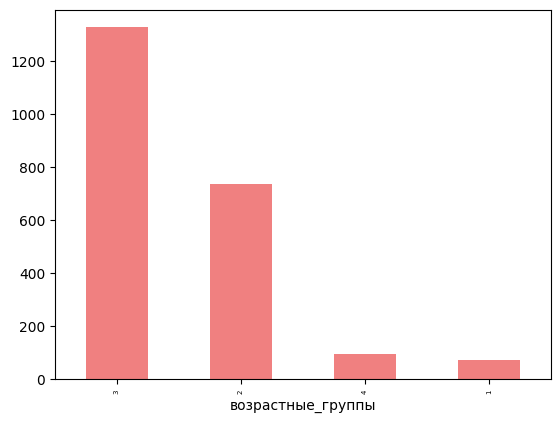

In [255]:
# попробуем добавить категорий в признак 'возрастные_группы'
# <30 лет - 0
# 30-45 лет - 1
# 45-60 лет - 2
# 60-75 лет - 3
# >75 лет - 4

new_cat = []
for meaning in df['возраст']:
    if meaning <= 30:
        new_cat.append(0)
    elif 30 < meaning <= 45:
        new_cat.append(1)
    elif 45 < meaning <= 60:
        new_cat.append(2)
    elif 60 < meaning <= 75:
        new_cat.append(3)
    else:
        new_cat.append(4)
df['возрастные_группы'] = new_cat 
df['возрастные_группы'].value_counts().plot(kind='bar', color='lightcoral');

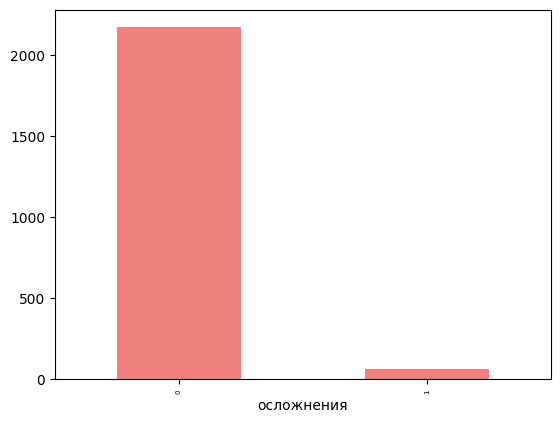

In [256]:
df['осложнения'].value_counts().plot(kind='bar', color='lightcoral');

In [257]:
# очень сильный дисбаланс классов целевой переменной

In [258]:
# приведем временные признаки к типу datetime и оставим только дату
df['дата_поступления'] = pd.to_datetime(df['дата_поступления'])
df['дата_поступления'] = df['дата_поступления'].dt.date
df['дата_операции'] = df['дата_операции'].dt.date

In [259]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2232 entries, 0 to 2231
Data columns (total 46 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   год                             2232 non-null   int64  
 1   пол(1м/2ж)                      2232 non-null   int64  
 2   возраст                         2232 non-null   int64  
 3   возрастные_группы               2232 non-null   int64  
 4   дата_поступления                2232 non-null   object 
 5   фк_стенокардии                  2232 non-null   int64  
 6   курение                         2232 non-null   bool   
 7   аг                              2232 non-null   int64  
 8   тип_СД2                         2232 non-null   int64  
 9   наличие_сд                      2232 non-null   bool   
 10  имт                             2207 non-null   float64
 11  степени_имт                     2207 non-null   float64
 12  охс                             14

In [260]:
df = transformator.time_between_check_inn_and_operation(df)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2232 entries, 0 to 2231
Data columns (total 47 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   год                             2232 non-null   int64  
 1   пол(1м/2ж)                      2232 non-null   int64  
 2   возраст                         2232 non-null   int64  
 3   возрастные_группы               2232 non-null   int64  
 4   дата_поступления                2232 non-null   object 
 5   фк_стенокардии                  2232 non-null   int64  
 6   курение                         2232 non-null   bool   
 7   аг                              2232 non-null   int64  
 8   тип_СД2                         2232 non-null   int64  
 9   наличие_сд                      2232 non-null   bool   
 10  имт                             2207 non-null   float64
 11  степени_имт                     2207 non-null   float64
 12  охс                             14

In [262]:
# генерация признаков по дате
df['дата_поступления'] = pd.to_datetime(df['дата_поступления'])
df['месяц_поступления'] = df['дата_поступления'].dt.month #apply(lambda time: time.month)
df['день_недели_поступления'] = df['дата_поступления'].dt.day_name()
df[['год', 'дата_поступления', 'дата_операции', 'месяц_поступления', 'день_недели_поступления', 'время_ожидания_операции']]

,год,дата_поступления,дата_операции,месяц_поступления,день_недели_поступления,время_ожидания_операции
0,2021,2021-05-24,2021-05-27,5,Monday,72.0
1,2021,2021-06-08,2021-06-09,6,Tuesday,24.0
2,2021,2021-02-24,2021-02-25,2,Wednesday,24.0
3,2021,2021-02-10,2021-02-11,2,Wednesday,24.0
4,2019,2019-08-26,2019-09-04,8,Monday,216.0
...,...,...,...,...,...,...
2227,2020,2020-08-10,2020-08-12,8,Monday,48.0
2228,2019,2019-09-16,2019-09-25,9,Monday,216.0
2229,2021,2021-04-16,2021-04-19,4,Friday,72.0
2230,2020,2020-04-09,2020-04-09,4,Thursday,0.0


In [266]:
# проверим на дубликаты
df.duplicated().sum()

0

In [270]:
df_copy = df.reset_index().copy()
df_copy.head(2)

,index,год,пол(1м/2ж),возраст,возрастные_группы,дата_поступления,фк_стенокардии,курение,аг,тип_СД2,...,стентирование_ствола_лка,шунтирование_пмжв,мкш_с_пмжв,время_ик,число_шунтов,акш_в_анамнезе,осложнения,время_ожидания_операции,месяц_поступления,день_недели_поступления
0,0,2021,1,75,3,2021-05-24,3,True,1,0,...,False,True,True,55,3,False,1,72.0,5,Monday
1,1,2021,1,74,3,2021-06-08,2,True,1,0,...,False,True,True,0,5,False,1,24.0,6,Tuesday


In [306]:
df_copy.pivot_table(index=['год','месяц_поступления'],
                                    values='index',
                                    aggfunc='count').sort_values(by=['год', 'месяц_поступления'], ascending=False)

index
год  месяц_поступления       
2021 12                     6
     8                      2
     7                     63
     6                     78
     5                     67
     4                     89
     3                     72
     2                     55
     1                     54
2020 12                    46
     11                    59
     10                    58
     9                     60
     8                     51
     7                     39
     6                     24
     5                     12
     4                     44
     3                     72
     2                     64
     1                     39
2019 12                    67
     11                    76
     10                    96
     9                     89
     8                     74
     7                     84
     6                     69
     5                     57
     4                     79
     3                     62
     2                     87
     1                     74
2018 12                    33
     11                    59
     10                   105
     9                     63
     8                      4

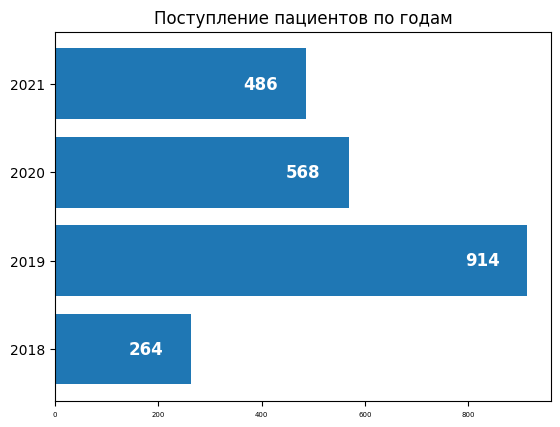

In [376]:
bars = plt.barh(df_copy['год'].sort_values(ascending=True).unique().astype('str'), df_copy.groupby('год')['index'].count(), height=0.8)
plt.bar_label(bars, padding=-45, color='white', 
             fontsize=12, label_type='edge', fontweight='bold')
plt.title('Поступление пациентов по годам')
plt.show()

In [381]:
df_copy.groupby(['год','возрастные_группы'])['index'].count() # нужен stacked barplot для визуализации по возрастным группам 

год   возрастные_группы
2018  1                      8
      2                     92
      3                    152
      4                     12
2019  1                     25
      2                    307
      3                    538
      4                     44
2020  1                     18
      2                    185
      3                    346
      4                     19
2021  1                     21
      2                    152
      3                    292
      4                     21
Name: index, dtype: int64

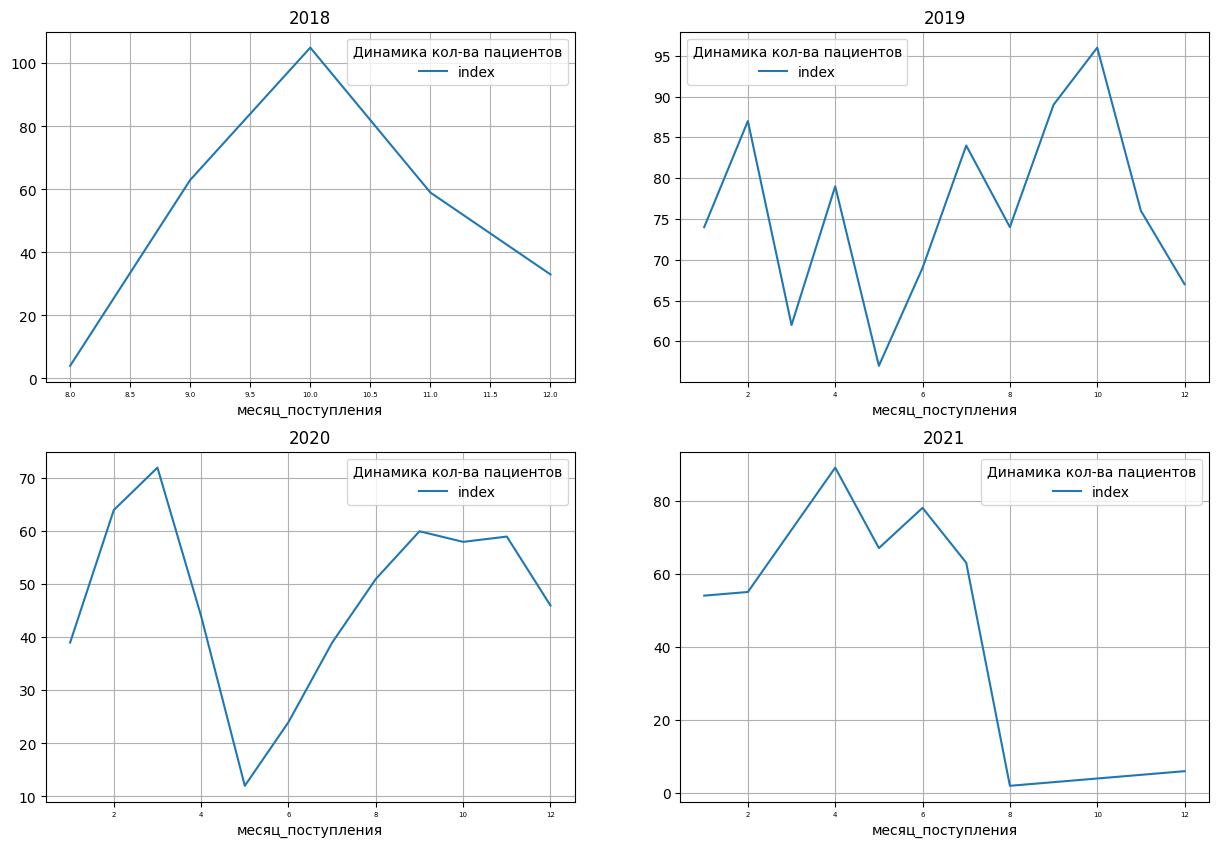

In [383]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))
for i, year in enumerate(df_copy['год'].sort_values(ascending=True).unique()):
    filtered = df_copy[df_copy['год'] == year]
    row_index = i // 2
    col_index = i % 2
    filtered.pivot_table(index='месяц_поступления',
                         values='index',
                         aggfunc='count').sort_values(by='месяц_поступления', 
                                                      ascending=False).plot(ax=axes[row_index, col_index],
                                                                            grid=True,
                                                                            title=year).get_legend().set_title("Динамика кол-ва пациентов")

In [363]:
# с декабря 2018 по январь 2019 был очень сильный рост поступивших (с ~33 по 74)
# весь 2019 год были "американские горки", почти на каждый четный месяц - рост, скачек - с 5 по 7 мес, под конец года сильный спад
# 2020 - пик пришелся на 3 мес, и к 5 месяцу падение в точку минимума к 9 месяцу опять рост почти до пиковых значений
# 2021 - сильный спад с 6 по 8 мес, дальше очень слабый рост

## Корреляционный анализ

interval columns not set, guessing: ['год', 'возраст', 'имт', 'охс', 'лпнп', 'креатинин', 'скф', 'офв_лж', 'euroscore1', 'euroscore2', 'время_ик', 'число_шунтов']


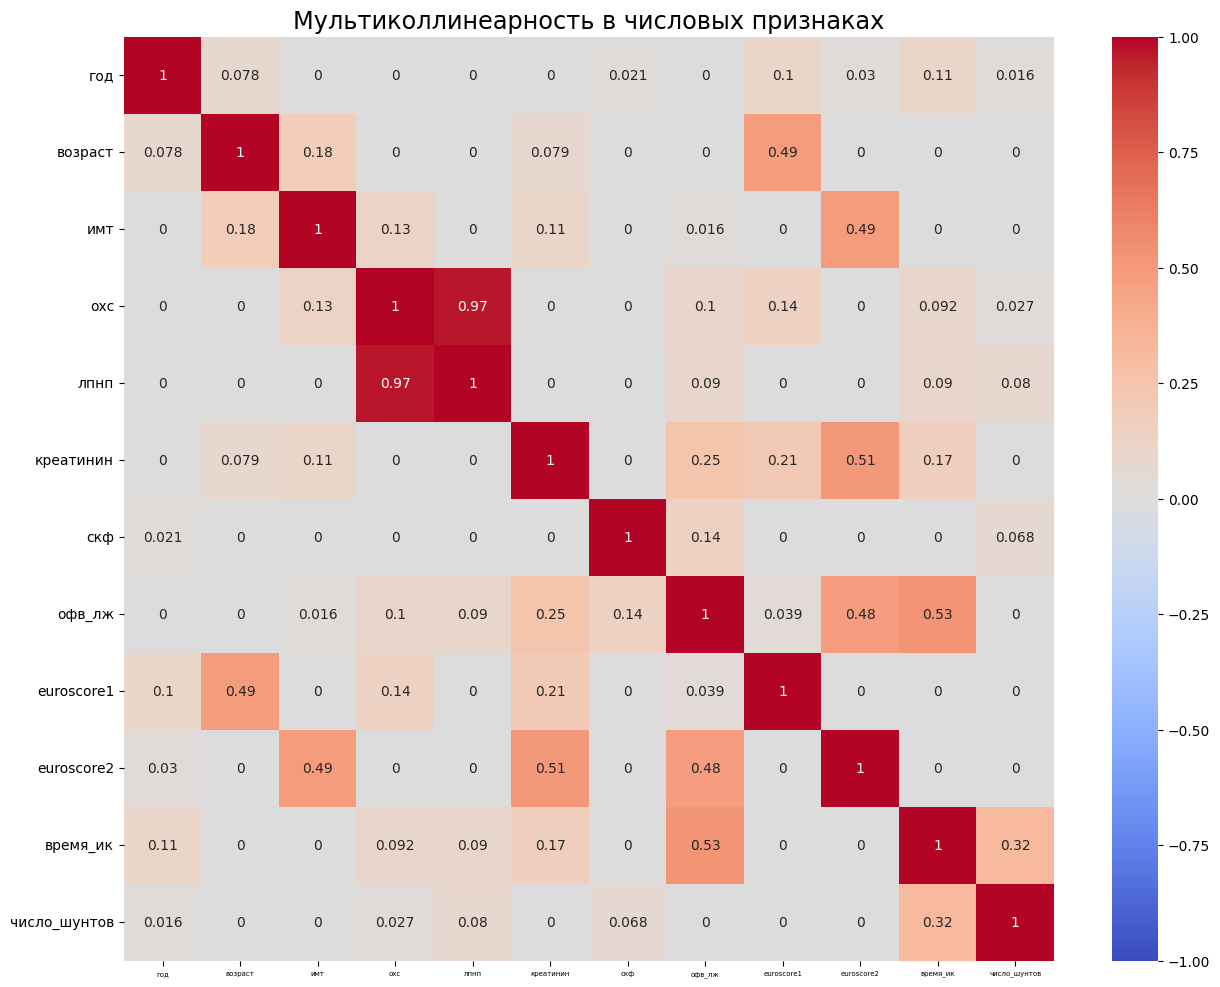

In [386]:
plt.figure(figsize=(15, 12))
sns.heatmap(df[['год', 'возраст', 'имт', 'охс', 'лпнп', 'креатинин', 'скф', 'офв_лж', 'euroscore1',
                'euroscore2', 'время_ик', 'число_шунтов']].phik_matrix(), annot=True, cmap='coolwarm', vmin=-1);
plt.title('Мультиколлинеарность в числовых признаках', fontsize='xx-large');
plt.show();

In [44]:
# мультиколлинеарность лпнп ?

## Моделирование

In [387]:
features = df.drop(columns = ['осложнения','дата_поступления', 'дата_операции'])
target = df['осложнения']
X_train, X_test, y_train, y_test = train_test_split(features, target,
                                                    test_size=TEST_SIZE,
                                                    stratify=target,
                                                    shuffle=True,
                                                    random_state=RANDOM_STATE)
print(X_train.shape)
print(X_test.shape)

print(y_train.shape)
print(y_test.shape)

(1562, 46)
(670, 46)
(1562,)
(670,)


In [388]:
categorial_features = ['пол(1м/2ж)', 'возрастные_группы', 'фк_стенокардии', 'аг',
                'тип_СД2', 'степени_имт', 'экг', 'euroscore1_abc',
                'cтепени_euroscore', 'курение', 'наличие_сд', 'хбп', 'чкв', 
                'мфа', 'пикс', 'сужение_вса>70%', 'сужение_магистр.артерий_нк>70%', 
                'поражение_ствола_лка>50%', 'поражение_пмжв',
                'поражение_1_мак', 'поражение_2_мак', 'поражение_3_мак', 
                'акш', 'с_ик', 'стентирование_ка', 'акш_тмлр', 'вабк',
                'стентирование_ствола_лка', 'шунтирование_пмжв',
                'мкш_с_пмжв', 'акш_в_анамнезе', 'возрастные_группы', 'день_недели_поступления']

numeric_features = ['год', 'возраст', 'имт', 'охс', 'лпнп', 'креатинин', 'скф', 'офв_лж', 'euroscore1',
                    'euroscore2', 'время_ик', 'число_шунтов', 'месяц_поступления', 'время_ожидания_операции']
print(len(categorial_features), len(numeric_features))

33 14


In [389]:
s_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

numeric_transformer_imb = ImbPipeline(
    steps=[("scaler", StandardScaler()),
           ("imputer", SimpleImputer(strategy="median", missing_values=np.nan))
          ]
)

# Предобработка категориальных признаков
categorical_transformer_imb = ImbPipeline(
    steps=[("encoder", OneHotEncoder(handle_unknown="ignore")),
           ("imputer", SimpleImputer(strategy='most_frequent', missing_values=np.nan))
          ]
)

# Преобразование признаков
data_preprocessor_imb = ColumnTransformer([
        ('num', numeric_transformer_imb, numeric_features),
        ('cat', categorical_transformer_imb, categorial_features)
    ],
    remainder='passthrough')

## RandomForestClassifier

In [390]:
rf_pipeline = ImbPipeline([
    ('preprocessor', data_preprocessor_imb),
    ('oversampler', SMOTETomek(random_state=RANDOM_STATE)),
    ('classifier', RandomForestClassifier(random_state=RANDOM_STATE))
])

rf_params = {
    'classifier__n_estimators': [25, 50, 75, 100],
    'classifier__min_samples_leaf': [2, 4, 6, 8],
    'classifier__max_depth': [6, 8, 10, 12],
    'classifier__criterion': ['gini', 'entropy'],
    'classifier__max_features': ['sqrt', 'log2', None],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__bootstrap': [True, False]
}

gs_rf = GridSearchCV(
    rf_pipeline,
    rf_params,
    cv=s_kfold,
    scoring='f1_macro',
    n_jobs=-1,
    error_score='raise'
)
gs_rf.fit(X_train, y_train)

print('Лучшая модель и её параметры:\n\n', gs_rf.best_estimator_)
print('Метрика лучшей модели на тренировочной выборке:', gs_rf.best_score_)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler()),
                                                                  ('imputer',
                                                                   SimpleImputer(strategy='median'))]),
                                                  ['год', 'возраст', 'имт',
                                                   'охс', 'лпнп', 'креатинин',
                                                   'скф', 'офв_лж',
                                                   'euroscore1', 'euroscore2',
                                                   'время_ик', 'число_шунтов',
                                                   'месяц_поступления',
                    

In [543]:
y_pred = gs_rf.best_estimator_.predict(X_test)
print(f"Точность модели на тестовой выборке: {f1_score(y_test, y_pred, average='macro')}")

Точность модели на тестовой выборке: 0.4897182025894897


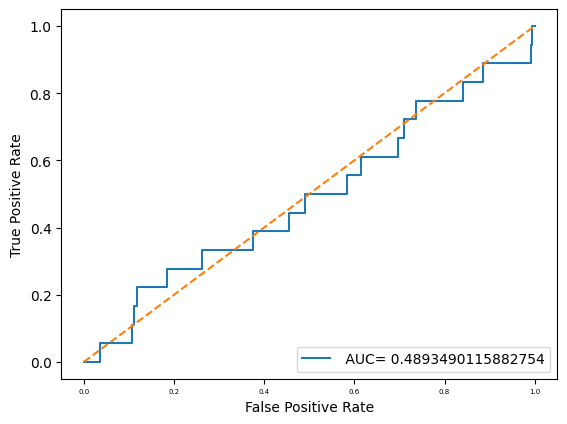

In [547]:
y_pred_proba = gs_rf.best_estimator_.predict_proba(X_test)[:,1]
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
auc = roc_auc_score(y_test, y_pred_proba)

#create ROC curve
plt.plot(fpr, tpr, label=" AUC= "+str(auc))
plt.plot([0,1], [0,1], linestyle='dashed',)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show() 

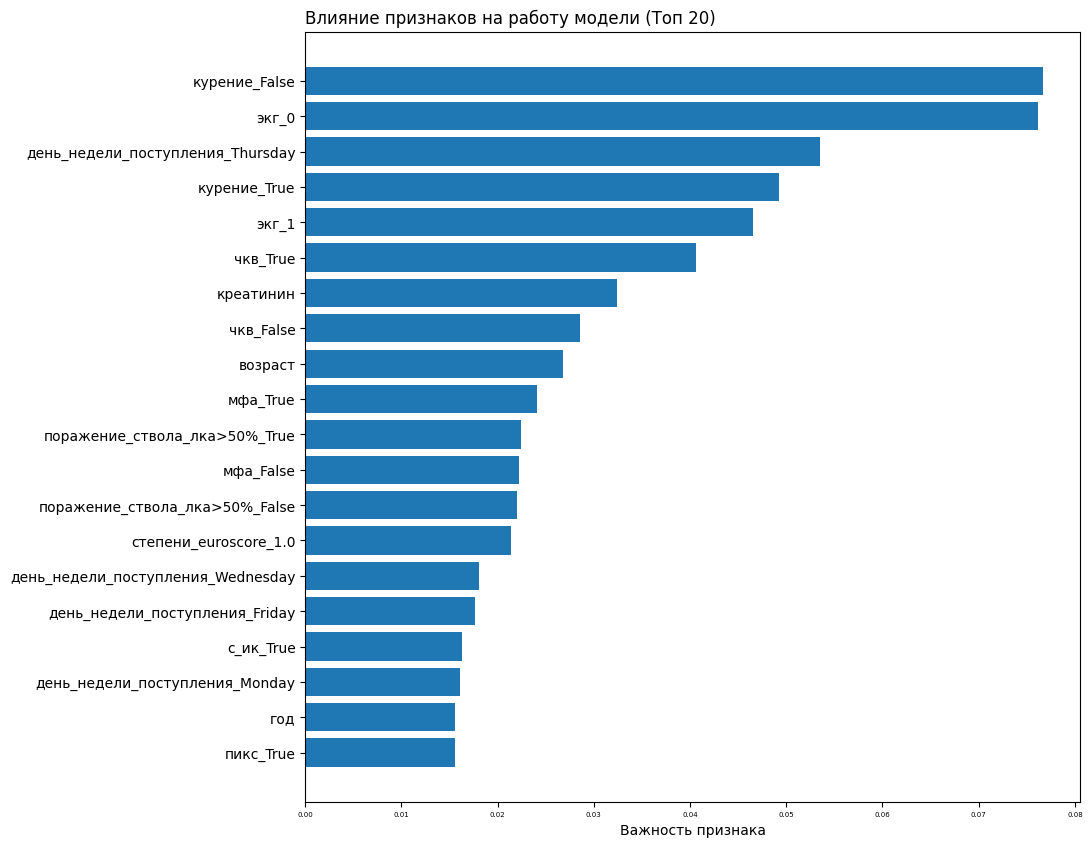

In [429]:
# Выводим график feature importance
column_names = gs_rf.best_estimator_.named_steps['preprocessor'].transformers_[1][1]\
                .get_feature_names_out(input_features=categorial_features)

feature_names = np.concatenate([numeric_features, column_names])

# Получение важности признаков из лучшего классификатора в пайплайне
importances = gs_rf.best_estimator_.named_steps['classifier'].feature_importances_

feature_importance(importances, feature_names)

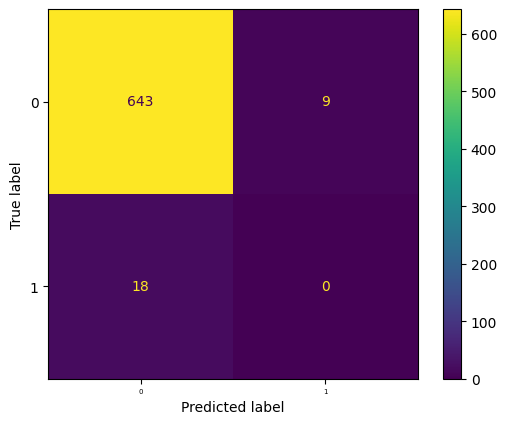

In [397]:
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred)).plot();

## LogisticRegression

In [468]:
lr_pipeline = ImbPipeline([
    ('preprocessor', data_preprocessor_imb),
    ('oversampler', SMOTETomek(random_state=RANDOM_STATE)),
    ('classifier', LogisticRegression(random_state=RANDOM_STATE))
])

lr_params = {
    'classifier__C': [0.1, 1, 10],
    'classifier__penalty': ['l1', 'l2'],
    'classifier__solver': ['liblinear', 'saga']
}

gs_lr = GridSearchCV(
    lr_pipeline,
    lr_params,
    cv=s_kfold,
    scoring='f1_macro',
    n_jobs=-1,
    error_score='raise'
)
gs_lr.fit(X_train, y_train)

print('Лучшая модель и её параметры:\n\n', gs_lr.best_estimator_)
print('Метрика лучшей модели на тренировочной выборке:', gs_lr.best_score_)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler()),
                                                                  ('imputer',
                                                                   SimpleImputer(strategy='median'))]),
                                                  ['год', 'возраст', 'имт',
                                                   'охс', 'лпнп', 'креатинин',
                                                   'скф', 'офв_лж',
                                                   'euroscore1', 'euroscore2',
                                                   'время_ик', 'число_шунтов',
                                                   'месяц_поступления',
                    

In [542]:
y_pred_lr = gs_lr.best_estimator_.predict(X_test)
print(f"Точность модели на тестовой выборке: {f1_score(y_test, y_pred_lr, average='macro')}")

Точность модели на тестовой выборке: 0.4429307852693247


In [556]:
# переберем пороги классификации для RF

In [419]:
y_proba_rf = gs_rf.best_estimator_.predict_proba(X_test)[:,1]
values = pd.DataFrame(zip(y_test, y_proba_rf),
                     columns=['y_valid', 'y_proba']).sort_values(by='y_proba',ascending=False)
values.head(5)

,y_valid,y_proba
559,0,0.595461
92,0,0.591848
75,0,0.564811
381,0,0.553209
90,0,0.548954


In [420]:
thresholds = [round(i,2) for i in np.linspace(0.1,1,num = 4,endpoint=False)]
print(thresholds) 

[0.1, 0.32, 0.55, 0.78]


In [521]:
# создаём переменную, которая будет хранить список новых колонок
columns = []

# добавим столбцы с новыми предсказаниями в таблицу
for i in thresholds:
	columns.append('y_pred_'+str(i))
	values['y_pred_'+str(i)] = values['y_proba'].apply(lambda x: 1 if x >= i else 0)# ваш код здесь)

print(values.query('y_valid == 1'))

     y_valid   y_proba  y_pred_0.1  y_pred_0.32  y_pred_0.55  y_pred_0.78
117        1  0.415796           1            1            0            0
135        1  0.327494           1            1            0            0
138        1  0.325966           1            1            0            0
423        1  0.321385           1            1            0            0
26         1  0.282626           1            0            0            0
437        1  0.240464           1            0            0            0
32         1  0.196020           1            0            0            0
190        1  0.164748           1            0            0            0
115        1  0.155522           1            0            0            0
370        1  0.134931           1            0            0            0
353        1  0.127679           1            0            0            0
332        1  0.109578           1            0            0            0
315        1  0.105936           1    

In [393]:
# 1) используем разные наборы данных для обучения моделей: c генерацией фичей и без
# 2) Сравниваем модели по roc_auc_score, по итогу для лучшей модели смотрим пороговую f1 macro на кроссвалидации
# 3) Каждый максимизирует метрику  roc_auc_score для одной-двух моделей (написать выбранные модели в чате)
# 4) Исследуем значимость признаков
# 5) Проверка гипотезы о том, что используя только данные до операции, можно предсказать осложнения 
# 6) исследуем возможность достижения высокой метрики на текущем датасете и оценим его адекватность для задачи

In [431]:
# обрезать дф до нужного кол-ва признаков
cut_df = df.drop(columns=['стентирование_ка', 'стентирование_ствола_лка', 'шунтирование_пмжв', 'число_шунтов'])
categorial_features_new = ['пол(1м/2ж)', 'возрастные_группы', 'фк_стенокардии', 'аг',
                'тип_СД2', 'степени_имт', 'экг', 'euroscore1_abc',
                'cтепени_euroscore', 'курение', 'наличие_сд', 'хбп', 'чкв', 
                'мфа', 'пикс', 'сужение_вса>70%', 'сужение_магистр.артерий_нк>70%', 
                'поражение_ствола_лка>50%', 'поражение_пмжв',
                'поражение_1_мак', 'поражение_2_мак', 'поражение_3_мак', 
                'акш', 'с_ик', 'акш_тмлр', 'вабк', 'мкш_с_пмжв', 'акш_в_анамнезе', 'день_недели_поступления']

numeric_features_new = ['год', 'возраст', 'имт', 'охс', 'лпнп', 'креатинин', 'скф', 'офв_лж', 'euroscore1',
                    'euroscore2', 'время_ик', 'месяц_поступления', 'время_ожидания_операции']
print(len(categorial_features_new), len(numeric_features_new))

29 13


In [548]:
features_cut = cut_df.drop(columns = ['осложнения','дата_поступления', 'дата_операции'])
target_cut = cut_df['осложнения']
X_train_cut, X_test_cut, y_train_cut, y_test_cut = train_test_split(features_cut, target_cut,
                                                    test_size=TEST_SIZE,
                                                    stratify=target_cut,
                                                    shuffle=True,
                                                    random_state=RANDOM_STATE)
print(X_train_cut.shape)
print(X_test_cut.shape)

print(y_train_cut.shape)
print(y_test_cut.shape)

(1562, 42)
(670, 42)
(1562,)
(670,)


In [432]:
numeric_transformer_imb_new = ImbPipeline(
    steps=[("scaler", StandardScaler()),
           ("imputer", SimpleImputer(strategy="median", missing_values=np.nan))
          ]
)

# Предобработка категориальных признаков
categorical_transformer_imb_new = ImbPipeline(
    steps=[("encoder", OneHotEncoder(handle_unknown="ignore")),
           ("imputer", SimpleImputer(strategy='most_frequent', missing_values=np.nan))
          ]
)

# Преобразование признаков
data_preprocessor_imb_new = ColumnTransformer([
        ('num', numeric_transformer_imb_new, numeric_features_new),
        ('cat', categorical_transformer_imb_new, categorial_features_new)
    ],
    remainder='passthrough')

## RandomForestClassifier на обрезанном наборе данных

In [553]:
rf_pipeline_new = ImbPipeline([
    ('preprocessor', data_preprocessor_imb_new),
    ('oversampler', SMOTE(random_state=RANDOM_STATE)),
    ('classifier', RandomForestClassifier(random_state=RANDOM_STATE))
])

rf_params_new = {
    'classifier__n_estimators': [25, 50, 75, 100],
    'classifier__min_samples_leaf': [2, 4, 6],
    'classifier__max_depth': [6, 8, None],
    'classifier__criterion': ['gini', 'entropy'],
    'classifier__max_features': ['sqrt', 'log2', None],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__bootstrap': [True, False]
}

gs_rf_new = GridSearchCV(
    rf_pipeline_new,
    rf_params_new,
    cv=s_kfold,
    scoring='f1_macro',
    n_jobs=-1,
    error_score='raise'
)
gs_rf_new.fit(X_train_cut, y_train_cut)

print('Лучшая модель и её параметры:\n\n', gs_rf_new.best_estimator_)
print('Метрика лучшей модели на тренировочной выборке:', gs_rf_new.best_score_)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler()),
                                                                  ('imputer',
                                                                   SimpleImputer(strategy='median'))]),
                                                  ['год', 'возраст', 'имт',
                                                   'охс', 'лпнп', 'креатинин',
                                                   'скф', 'офв_лж',
                                                   'euroscore1', 'euroscore2',
                                                   'время_ик',
                                                   'месяц_поступления',
                                    

In [559]:
y_pred_new = gs_rf_new.best_estimator_.predict(X_test_cut)
print(f"Точность модели на тестовой выборке: {f1_score(y_test_cut, y_pred_new, average='macro')}")

Точность модели на тестовой выборке: 0.4897182025894897


In [568]:
# метрики модели на полном датафрейме и обрезанном не отличаются, пока, можно предположить, что информация о пациенте после операции
# либо вовсе не влияет, либо не сильно влияет на предсказание осложнений
# поэтому, пока дальнейшие расчеты будет проводить на полном датасете

## CatBoostClassifier

In [560]:
cb_pipeline = ImbPipeline([
    ('preprocessor', data_preprocessor_imb),
    ('oversampler', RandomOverSampler(random_state=RANDOM_STATE)),
    ('classifier', CatBoostClassifier())
])

cb_params = {
     'classifier__iterations': [25, 50, 150],  
     'classifier__learning_rate': [0.1, 0.3, 0.5],
     'classifier__depth': [6, 8, 10, 12] 
}

gs_cb = GridSearchCV(
    cb_pipeline,
    cb_params,
    cv=s_kfold,
    scoring='f1_macro',
    n_jobs=-1,
    error_score='raise'
)
gs_cb.fit(X_train, y_train)

print('Лучшая модель и её параметры:\n\n', gs_cb.best_estimator_)
print('Метрика лучшей модели на тренировочной выборке:', gs_cb.best_score_)

0:	learn: 0.4629272	total: 14.6ms	remaining: 2.18s
1:	learn: 0.3511992	total: 24.9ms	remaining: 1.84s
2:	learn: 0.2223701	total: 35.1ms	remaining: 1.72s
3:	learn: 0.1518354	total: 43.9ms	remaining: 1.6s
4:	learn: 0.1018962	total: 53.6ms	remaining: 1.55s
5:	learn: 0.0749467	total: 62.9ms	remaining: 1.51s
6:	learn: 0.0592343	total: 72.7ms	remaining: 1.49s
7:	learn: 0.0485581	total: 81.3ms	remaining: 1.44s
8:	learn: 0.0400319	total: 89.8ms	remaining: 1.41s
9:	learn: 0.0275970	total: 98.3ms	remaining: 1.38s
10:	learn: 0.0227423	total: 107ms	remaining: 1.35s
11:	learn: 0.0187021	total: 115ms	remaining: 1.32s
12:	learn: 0.0142555	total: 123ms	remaining: 1.3s
13:	learn: 0.0129238	total: 132ms	remaining: 1.28s
14:	learn: 0.0113310	total: 141ms	remaining: 1.26s
15:	learn: 0.0099225	total: 150ms	remaining: 1.25s
16:	learn: 0.0083969	total: 160ms	remaining: 1.25s
17:	learn: 0.0074350	total: 171ms	remaining: 1.25s
18:	learn: 0.0068163	total: 179ms	remaining: 1.24s
19:	learn: 0.0062829	total: 188ms

In [561]:
y_pred_cb = gs_cb.best_estimator_.predict(X_test)
print(f"Точность модели на тестовой выборке: {f1_score(y_test, y_pred_cb, average='macro')}")

Точность модели на тестовой выборке: 0.4920394238059136


## LGBMClassifier

In [562]:
lgbm_pipeline = ImbPipeline([
    ('preprocessor', data_preprocessor_imb),
    ('oversampler', RandomOverSampler(random_state=RANDOM_STATE)),
    ('classifier', LGBMClassifier(random_state=RANDOM_STATE))
])

lgbm_params = {
     'classifier__learning_rate':[0.1, 0.03, 0.05],
     'classifier__num_leaves': [15, 20, 25],
     'classifier__max_depth': [2, 4, 6, 8, 10],
     'classifier__objective': ['binary', 'regression'],
     'classifier__boosting': ['gbdt', 'dart']
}

gs_lgbm = GridSearchCV(
    lgbm_pipeline,
    lgbm_params,
    cv=s_kfold,
    scoring='f1_macro',
    n_jobs=-1,
    error_score='raise'
)
gs_lgbm.fit(X_train, y_train)

print('Лучшая модель и её параметры:\n\n', gs_lgbm.best_estimator_)
print('Метрика лучшей модели на тренировочной выборке:', gs_lgbm.best_score_)

[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000722 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2112
[LightGBM] [Info] Number of data points in the train set: 3038, number of used features: 96
[LightGBM] [Info] Start training from score 0.500000
Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler()),
                                  

In [563]:
y_pred_lgbm = gs_lgbm.best_estimator_.predict(X_test)
print(f"Точность модели на тестовой выборке: {f1_score(y_test, y_pred_lgbm, average='macro')}")

[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
Точность модели на тестовой выборке: 0.4990544047147821


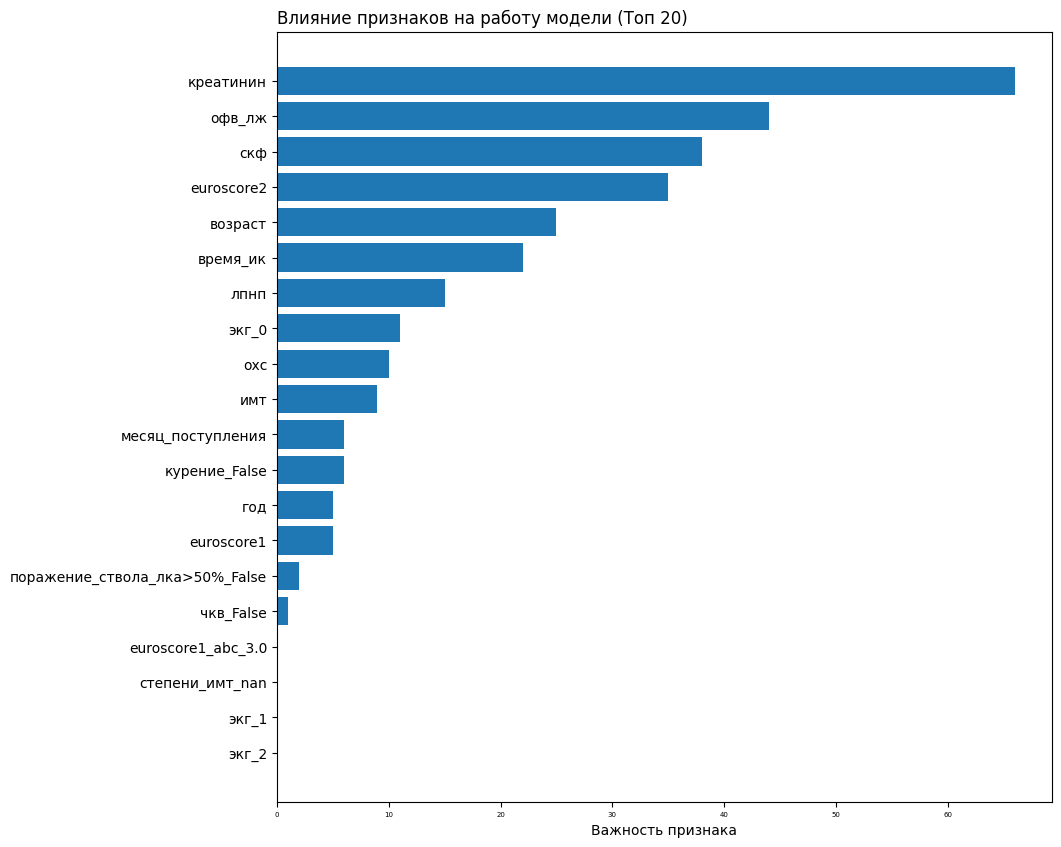

In [564]:
# Выводим график feature importance
column_names_lgbm = gs_lgbm.best_estimator_.named_steps['preprocessor'].transformers_[1][1]\
                .get_feature_names_out(input_features=categorial_features)

feature_names_lgbm = np.concatenate([numeric_features, column_names_lgbm])

# Получение важности признаков из лучшего классификатора в пайплайне
importances_lgbm = gs_lgbm.best_estimator_.named_steps['classifier'].feature_importances_

feature_importance(importances_lgbm, feature_names_lgbm)

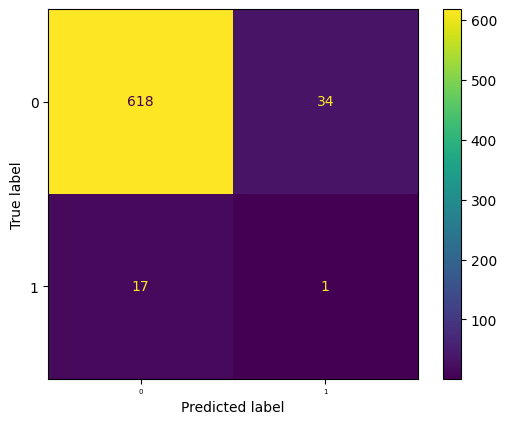

In [565]:
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_lgbm)).plot();

[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart


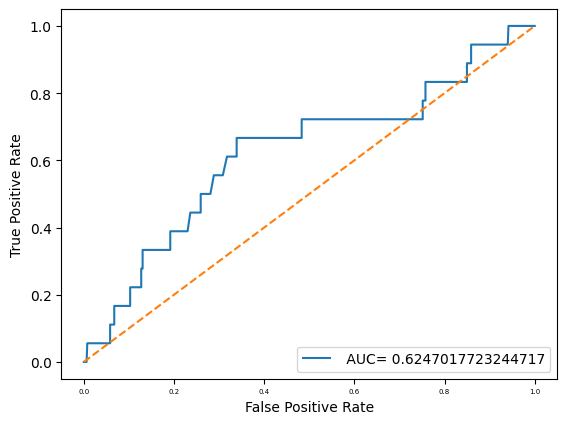

In [526]:
y_pred_proba_lgbm = gs_lgbm.best_estimator_.predict_proba(X_test)[:,1]
fpr_lgbm, tpr_lgbm, thresholds = roc_curve(y_test, y_pred_proba_lgbm)
auc_lgbm = roc_auc_score(y_test, y_pred_proba_lgbm)

#create ROC curve
plt.plot(fpr_lgbm, tpr_lgbm, label=" AUC= "+str(auc_lgbm))
plt.plot([0,1], [0,1], linestyle='dashed',)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

In [527]:
optimal_idx = np.argmax(tpr_lgbm - fpr_lgbm)
optimal_threshold = thresholds[optimal_idx]
print("Threshold value is:", optimal_threshold)

Threshold value is: 0.30814117136219604


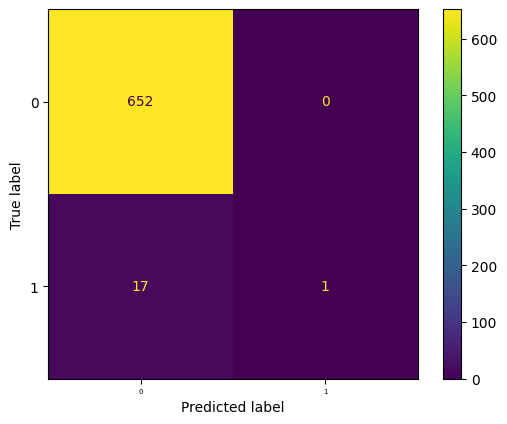

In [535]:
predictions = (y_pred_proba_lgbm == optimal_threshold).astype(int)
ConfusionMatrixDisplay(confusion_matrix(y_test, predictions)).plot();

In [544]:
print(f"Точность модели на тестовой выборке: {f1_score(y_test, predictions, average='macro')}")

Точность модели на тестовой выборке: 0.5461970596438105


## Проверка гипотез

### Полный датасет

In [569]:
# H0 - для предсказания осложнений данных достаточно
# Н1 - для предсказания осложнений данных не достаточно
alpha = 0.05
results = stats.ttest_ind(y_test, y_pred)
print('p-значение: ', results.pvalue)
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-значение:  0.0802675678147302
Не получилось отвергнуть нулевую гипотезу


### Только с признаками, известными до операции

In [570]:
# H0 - для предстазания осложнений данных достаточно
# Н1 - для предстазания осложнений данных не достаточно

result_new = stats.ttest_ind(y_test, y_pred_new)
print('p-значение: ', results.pvalue)
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-значение:  0.0802675678147302
Не получилось отвергнуть нулевую гипотезу
